# Tidy Text Case Studies

## Install Packages

In [2]:
install.packages("lubridate")
install.packages("ggplot2")
install.packages("dplyr")
install.packages("readr")


The downloaded binary packages are in
	/var/folders/2h/84wxzls579b1yv00g4jj02fh0000gn/T//RtmpgBw78X/downloaded_packages

The downloaded binary packages are in
	/var/folders/2h/84wxzls579b1yv00g4jj02fh0000gn/T//RtmpgBw78X/downloaded_packages

The downloaded binary packages are in
	/var/folders/2h/84wxzls579b1yv00g4jj02fh0000gn/T//RtmpgBw78X/downloaded_packages

The downloaded binary packages are in
	/var/folders/2h/84wxzls579b1yv00g4jj02fh0000gn/T//RtmpgBw78X/downloaded_packages


## Case study: Comparing Twitter Archives

Online text, especially from platforms like Twitter, receives a lot of attention in text analysis. Many sentiment lexicons used in this book were specifically designed for or validated on tweets, reflecting the unique language and style found there. Both authors of this book are active Twitter users, so this case study explores a comparison between the entire Twitter archives of [Julia](https://x.com/juliasilge) and [David](https://x.com/drob).


### Getting the Data and Distribution

Individuals can download their own Twitter archives by following [instructions provided on Twitter’s website](https://help.x.com/en/managing-your-account/how-to-download-your-x-archive). After downloading their archives, the next step is to load the data and use the **lubridate** package to convert the string-formatted timestamps into proper date-time objects. This conversion enables easier analysis of tweeting patterns over time. Initially, we can explore overall tweeting behavior by summarizing or visualizing the frequency and timing of tweets.



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




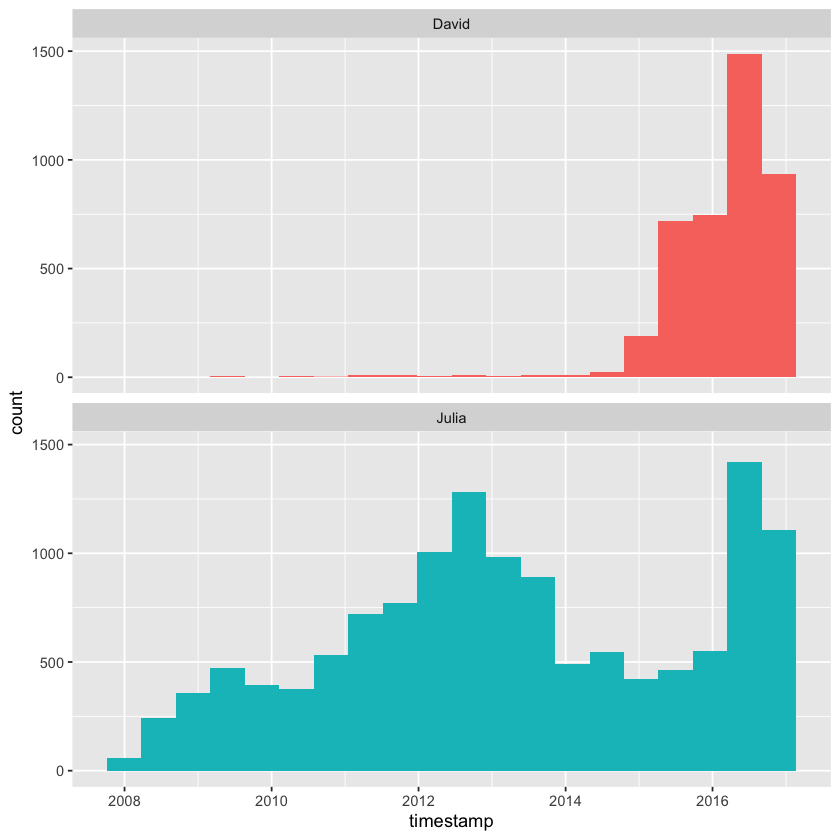

In [5]:
library(lubridate)
library(ggplot2)
library(dplyr)
library(readr)

tweets_julia <- read_csv("data/tweets_julia.csv", show_col_types = FALSE)
tweets_dave <- read_csv("data/tweets_dave.csv", show_col_types = FALSE)
tweets <- bind_rows(tweets_julia %>% 
                      mutate(person = "Julia"),
                    tweets_dave %>% 
                      mutate(person = "David")) %>%
  mutate(timestamp = ymd_hms(timestamp))

ggplot(tweets, aes(x = timestamp, fill = person)) +
  geom_histogram(position = "identity", bins = 20, show.legend = FALSE) +
  facet_wrap(~person, ncol = 1)

David and Julia currently tweet at roughly the same rate and joined Twitter about a year apart, but there was a period of about five years when David was inactive on the platform while Julia remained active. As a result, Julia has accumulated approximately four times as many tweets as David overall.

### Word Frequencies

We’ll use [`unnest_tokens()`](https://juliasilge.github.io/tidytext/reference/unnest_tokens.html) to create a tidy data frame containing all the words from our tweets and remove common English stop words. Since people use text on Twitter differently than in traditional narratives, we’ll use a specialized tokenizer and apply some additional text cleaning compared to what we did with Project Gutenberg text.

First, we’ll filter out retweets from the dataset to focus only on tweets we wrote ourselves. Then, the [`mutate()`](https://dplyr.tidyverse.org/reference/mutate.html) step removes links and unwanted characters like ampersands and other symbols.

In the [`unnest_tokens()`](https://juliasilge.github.io/tidytext/reference/unnest_tokens.html) call, we use a regular expression pattern instead of extracting simple unigrams. This regex is particularly helpful for handling Twitter text or content from online platforms—it keeps hashtags and @ mentions intact.

Because hashtags and usernames remain in the dataset, using a basic [`anti_join()`](https://dplyr.tidyverse.org/reference/filter-joins.html) to remove stop words isn’t sufficient. Instead, the [`filter()`](https://dplyr.tidyverse.org/reference/filter.html) line demonstrates how to use [`str_detect()`](https://stringr.tidyverse.org/reference/str_detect.html) from the **stringr** package to exclude stop words more effectively.


In [6]:
library(tidytext)
library(stringr)

replace_reg <- "https://t.co/[A-Za-z\\d]+|http://[A-Za-z\\d]+|&amp;|&lt;|&gt;|RT|https"
unnest_reg <- "([^A-Za-z_\\d#@']|'(?![A-Za-z_\\d#@]))"

tidy_tweets <- tweets %>% 
  filter(!str_detect(text, "^RT")) %>%
  mutate(text = str_replace_all(text, replace_reg, "")) %>%
  unnest_tokens(word, text, token = "regex", pattern = unnest_reg) %>%
  filter(!word %in% stop_words$word,
         !word %in% str_remove_all(stop_words$word, "'"),
         str_detect(word, "[a-z]"))

We can now compute word frequencies for each individual. To do this, we first group the data by person and word, counting the number of times each word appears per person. Next, we perform a [`left\_join()`](https://dplyr.tidyverse.org/reference/mutate-joins.html) to bring in the total word counts for each person — Julia’s total is larger since she has more tweets overall. Finally, we calculate the frequency of each word for each person by dividing the word count by the total words they used.

In [10]:
frequency <- tidy_tweets %>% 
  count(person, word, sort = TRUE) %>% 
  left_join(tidy_tweets %>% 
              count(person, name = "total")) %>%
  mutate(freq = n/total)

print(frequency)

Joining with `by = join_by(person)`


# A tibble: 20,722 x 5
   person word               n total    freq
   <chr>  <chr>          <int> <int>   <dbl>
 1 Julia  time             584 74541 0.00783
 2 Julia  @selkie1970      570 74541 0.00765
 3 Julia  @skedman         531 74541 0.00712
 4 Julia  day              467 74541 0.00627
 5 Julia  baby             408 74541 0.00547
 6 David  @hadleywickham   315 20150 0.0156 
 7 Julia  love             304 74541 0.00408
 8 Julia  @haleynburke     299 74541 0.00401
 9 Julia  house            289 74541 0.00388
10 Julia  morning          278 74541 0.00373
# i 20,712 more rows


This gives us a clean and tidy data frame, but to visualize those frequencies with one person’s frequency on the x-axis and the other’s on the y-axis, we need to reshape the data. We can use tidyr’s [`pivot\_wider()`](https://tidyr.tidyverse.org/reference/pivot_wider.html) function to transform the data frame so that each person’s word frequencies become separate columns, ready for plotting.

In [11]:
library(tidyr)

frequency <- frequency %>% 
  select(person, word, freq) %>% 
  pivot_wider(names_from = person, values_from = freq) %>%
  arrange(Julia, David)

print(frequency)

# A tibble: 17,629 x 3
   word                 Julia     David
   <chr>                <dbl>     <dbl>
 1 's               0.0000134 0.0000496
 2 1x               0.0000134 0.0000496
 3 5k               0.0000134 0.0000496
 4 @accidental__art 0.0000134 0.0000496
 5 @alice_data      0.0000134 0.0000496
 6 @alistaire       0.0000134 0.0000496
 7 @corynissen      0.0000134 0.0000496
 8 @jennybryan's    0.0000134 0.0000496
 9 @jsvine          0.0000134 0.0000496
10 @lizasperling    0.0000134 0.0000496
# i 17,619 more rows


This reshaped data is now ready for visualization. We can use [`geom_jitter()`](https://ggplot2.tidyverse.org/reference/geom_jitter.html) to help spread out the points, reducing the visual clumping that happens with low-frequency words. Additionally, setting `check_overlap = TRUE` on the text labels will prevent them from overlapping excessively, so only a subset of labels will appear clearly on the plot.

Warning message:
"Removed 14536 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 14536 rows containing missing values or values outside the scale range
(`geom_text()`)."


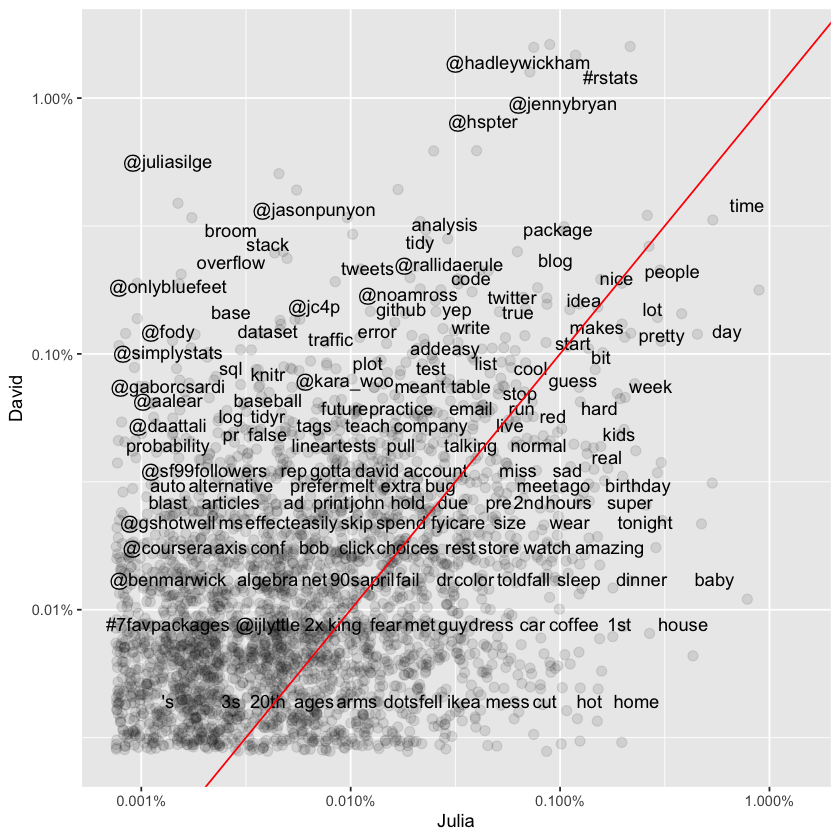

In [12]:
suppressPackageStartupMessages(library(scales))

ggplot(frequency, aes(Julia, David)) +
  geom_jitter(alpha = 0.1, size = 2.5, width = 0.25, height = 0.25) +
  geom_text(aes(label = word), check_overlap = TRUE, vjust = 1.5) +
  scale_x_log10(labels = percent_format()) +
  scale_y_log10(labels = percent_format()) +
  geom_abline(color = "red")

Words that fall close to the diagonal line on the plot are used at roughly equal rates by both David and Julia. In contrast, words that sit farther from the line are more heavily favored by one person over the other. The plot only shows words, hashtags, and usernames that both individuals have used at least once in their tweets.

It’s clear from this visualization—and will continue to be throughout the chapter—that David and Julia have approached Twitter in very different ways over the years. David's tweets have been almost entirely professional since he became active, whereas Julia's early Twitter use was personal, and even now, her account retains more personal content than David's. This difference in usage patterns is reflected immediately in how they use language on the platform.

### Comparing Word Usage

We’ve already visualized a comparison of raw word frequencies across the entire Twitter histories of David and Julia. Now, let’s dig deeper by identifying which words are more or less likely to originate from each person’s account using the log odds ratio. To keep the comparison meaningful, we’ll limit the analysis to tweets from 2016—a year when David was consistently active on Twitter and Julia was transitioning into her data science career.

In [13]:
tidy_tweets <- tidy_tweets %>%
  filter(timestamp >= as.Date("2016-01-01"),
         timestamp < as.Date("2017-01-01"))

Next, we’ll use [`str_detect()`](https://stringr.tidyverse.org/reference/str_detect.html) to filter out Twitter usernames from our word column. Otherwise, the analysis would be dominated by names of people David or Julia know, which doesn’t tell us much about broader word usage differences.

Once usernames are removed, we count how many times each person uses each word and keep only words that appear more than 10 times to avoid results driven by very rare terms. After reshaping the data with [`pivot_wider()`](https://tidyr.tidyverse.org/reference/pivot_wider.html), we calculate the **log odds ratio** for each word as:

$$
\text{log odds ratio} = \ln \left( \frac{(n + 1) / (total + 1) \text{ for David}}{(n + 1) / (total + 1) \text{ for Julia}} \right)
$$

Here:

* $n$ is the count of the word for each person,
* $total$ is the total word count for each person,
* Adding 1 to both numerator and denominator prevents division by zero for rare words.

This gives a clearer picture of which words are disproportionately associated with one person versus the other.


In [14]:
word_ratios <- tidy_tweets %>%
  filter(!str_detect(word, "^@")) %>%
  count(word, person) %>%
  group_by(word) %>%
  filter(sum(n) >= 10) %>%
  ungroup() %>%
  pivot_wider(names_from = person, values_from = n, values_fill = 0) %>%
  mutate_if(is.numeric, list(~(. + 1) / (sum(.) + 1))) %>%
  mutate(logratio = log(David / Julia)) %>%
  arrange(desc(logratio))

Here are some words that have been about equally likely to come from David or Julia’s account during 2016.

In [15]:
word_ratios %>% 
  arrange(abs(logratio)) %>%
  print()

# A tibble: 377 x 4
   word         David   Julia logratio
   <chr>        <dbl>   <dbl>    <dbl>
 1 email      0.00229 0.00228  0.00463
 2 file       0.00229 0.00228  0.00463
 3 map        0.00252 0.00254 -0.00543
 4 names      0.00413 0.00406  0.0170 
 5 account    0.00183 0.00177  0.0328 
 6 api        0.00183 0.00177  0.0328 
 7 function   0.00367 0.00355  0.0328 
 8 population 0.00183 0.00177  0.0328 
 9 sad        0.00183 0.00177  0.0328 
10 words      0.00367 0.00355  0.0328 
# i 367 more rows


We are about equally likely to tweet about maps, email, files, and APIs.

To find the words most strongly associated with each account, we select the top 15 words with the highest positive log odds ratio (most likely from David’s account) and the top 15 words with the lowest (most negative) log odds ratio (most likely from Julia’s account).

Plotting these words will clearly show which terms are most distinctive for each person’s tweets, highlighting the differences in their language use during 2016.

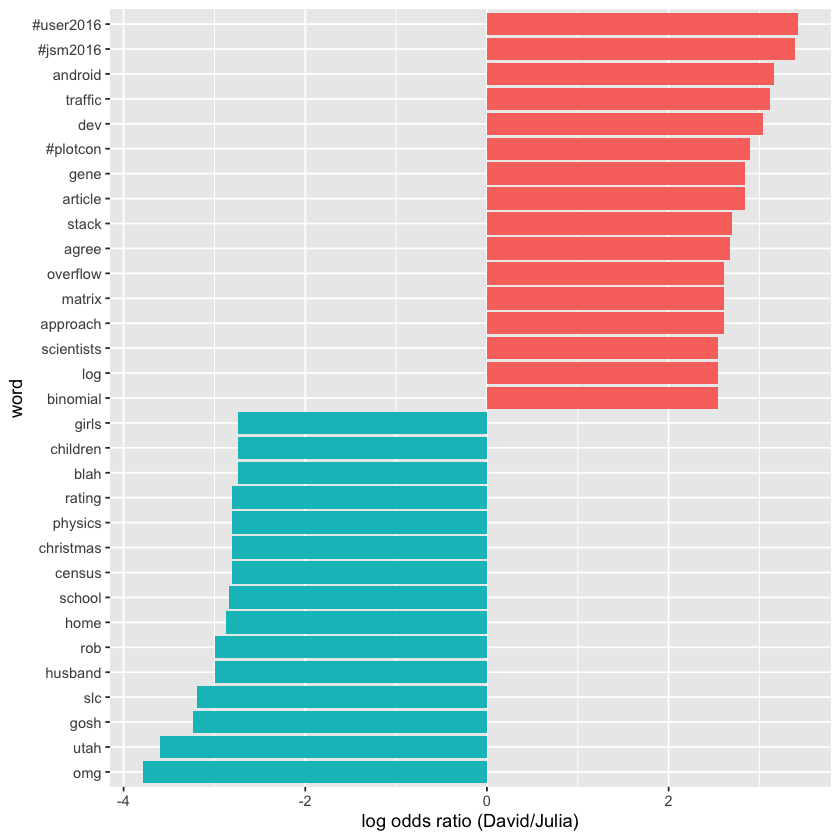

In [16]:
word_ratios %>%
  group_by(logratio < 0) %>%
  slice_max(abs(logratio), n = 15) %>% 
  ungroup() %>%
  mutate(word = reorder(word, logratio)) %>%
  ggplot(aes(word, logratio, fill = logratio < 0)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  ylab("log odds ratio (David/Julia)") +
  scale_fill_discrete(name = "", labels = c("David", "Julia"))

David’s tweets tend to focus on professional topics like conferences and programming, reflecting his career interests, while Julia’s tweets highlight personal themes like family and regional topics such as Utah and Census data.

### Changes in Word Use

The previous section focused on overall word usage, but now we want to explore a different question: which words have changed in frequency the most over time in the Twitter feeds? In other words, which words have they tweeted about more or less as time has gone on?

To analyze this, we first create a new time variable in the data frame that groups each tweet into a specific time unit. Using lubridate’s [`floor_date()`](https://lubridate.tidyverse.org/reference/round_date.html) function, we round timestamps down to the start of each month, which works well for this year of tweets.

Once these time bins are set, we count how often each person used each word within each month. Then, we add columns showing the total words tweeted by each person per month and the total uses of each word by each person overall. Finally, we can [`filter()`](https://dplyr.tidyverse.org/reference/filter.html) the data to keep only words that appear at least 30 times, ensuring we focus on words with sufficient usage for meaningful analysis.


In [17]:
words_by_time <- tidy_tweets %>%
  filter(!str_detect(word, "^@")) %>%
  mutate(time_floor = floor_date(timestamp, unit = "1 month")) %>%
  count(time_floor, person, word) %>%
  group_by(person, time_floor) %>%
  mutate(time_total = sum(n)) %>%
  group_by(person, word) %>%
  mutate(word_total = sum(n)) %>%
  ungroup() %>%
  rename(count = n) %>%
  filter(word_total > 30)

print(words_by_time)

# A tibble: 327 x 6
   time_floor          person word    count time_total word_total
   <dttm>              <chr>  <chr>   <int>      <int>      <int>
 1 2016-01-01 00:00:00 David  #rstats     2        306        208
 2 2016-01-01 00:00:00 David  broom       2        306         39
 3 2016-01-01 00:00:00 David  data        2        306        165
 4 2016-01-01 00:00:00 David  ggplot2     1        306         39
 5 2016-01-01 00:00:00 David  tidy        1        306         46
 6 2016-01-01 00:00:00 David  time        2        306         58
 7 2016-01-01 00:00:00 David  tweets      1        306         46
 8 2016-01-01 00:00:00 Julia  #rstats    10        401        116
 9 2016-01-01 00:00:00 Julia  blog        2        401         33
10 2016-01-01 00:00:00 Julia  data        5        401        111
# i 317 more rows


Each row in this data frame represents a single person’s use of a specific word within a particular time bin. The `count` column shows how many times that person used the word in that time period, `time_total` gives the total number of words the person tweeted during that time bin, and `word_total` indicates the total number of times that person used that word throughout the entire year. This dataset is ready to be used for modeling purposes.

Next, we can apply [`nest()`](https://tidyr.tidyverse.org/reference/nest.html) from tidyr to create a data frame where each word corresponds to a list-column containing smaller data frames—essentially mini datasets—for each word. Let’s go ahead and do that, then examine the structure of the resulting nested data frame.

In [18]:
nested_data <- words_by_time %>%
  nest(data = c(-word, -person)) 

print(nested_data)

# A tibble: 32 x 3
   person word    data             
   <chr>  <chr>   <list>           
 1 David  #rstats <tibble [12 x 4]>
 2 David  broom   <tibble [10 x 4]>
 3 David  data    <tibble [12 x 4]>
 4 David  ggplot2 <tibble [10 x 4]>
 5 David  tidy    <tibble [11 x 4]>
 6 David  time    <tibble [12 x 4]>
 7 David  tweets  <tibble [8 x 4]> 
 8 Julia  #rstats <tibble [12 x 4]>
 9 Julia  blog    <tibble [10 x 4]>
10 Julia  data    <tibble [12 x 4]>
# i 22 more rows


This data frame contains one row for each unique person-word pair, and the `data` column is a list-column holding smaller data frames for each of those pairs. We’ll use [`map()`](https://purrr.tidyverse.org/reference/map.html) from the purrr package [(Henry and Wickham 2018)](https://www.tidytextmining.com/references#ref-R-purrr) to run our modeling function on each of these nested data frames.

Since the data involves counts, we’ll fit a generalized linear model using [`glm()`](https://rdrr.io/r/stats/glm.html) with `family = "binomial"`. Essentially, this model answers a question like: “Was this particular word mentioned during this time bin (yes or no)? How does the likelihood of mentioning this word change over time?”

In [19]:
suppressPackageStartupMessages(library(purrr))

nested_models <- nested_data %>%
  mutate(models = map(data, ~ glm(cbind(count, time_total) ~ time_floor, ., 
                                  family = "binomial")))

print(nested_models)

# A tibble: 32 x 4
   person word    data              models
   <chr>  <chr>   <list>            <list>
 1 David  #rstats <tibble [12 x 4]> <glm> 
 2 David  broom   <tibble [10 x 4]> <glm> 
 3 David  data    <tibble [12 x 4]> <glm> 
 4 David  ggplot2 <tibble [10 x 4]> <glm> 
 5 David  tidy    <tibble [11 x 4]> <glm> 
 6 David  time    <tibble [12 x 4]> <glm> 
 7 David  tweets  <tibble [8 x 4]>  <glm> 
 8 Julia  #rstats <tibble [12 x 4]> <glm> 
 9 Julia  blog    <tibble [10 x 4]> <glm> 
10 Julia  data    <tibble [12 x 4]> <glm> 
# i 22 more rows


Now we see a new column holding the modeling results—this is another list-column, each entry containing a `glm` model object. The next step is to use [`map()`](https://purrr.tidyverse.org/reference/map.html) together with [`tidy()`](https://generics.r-lib.org/reference/tidy.html) from the broom package to extract the slope coefficients from each model.

Since we’re testing many slopes simultaneously and some won’t be statistically significant, we’ll adjust the p-values to account for multiple comparisons, helping to control for false positives.

In [20]:
library(broom)

slopes <- nested_models %>%
  mutate(models = map(models, tidy)) %>%
  unnest(cols = c(models)) %>%
  filter(term == "time_floor") %>%
  mutate(adjusted.p.value = p.adjust(p.value))

Next, we’ll identify the most notable slopes—that is, the words whose usage frequencies have changed over time with moderate statistical significance in our tweets. By filtering the results for adjusted p-values below a chosen threshold (e.g., 0.05), we can pinpoint these words and understand which topics or terms have become more or less common during the period analyzed.

In [21]:
top_slopes <- slopes %>% 
  filter(adjusted.p.value < 0.05)

print(top_slopes)

# A tibble: 6 x 9
  person word      data              term   estimate std.error statistic p.value
  <chr>  <chr>     <list>            <chr>     <dbl>     <dbl>     <dbl>   <dbl>
1 David  ggplot2   <tibble [10 x 4]> time_~ -8.27e-8   1.97e-8     -4.20 2.69e-5
2 Julia  #rstats   <tibble [12 x 4]> time_~ -4.49e-8   1.12e-8     -4.01 5.97e-5
3 Julia  post      <tibble [12 x 4]> time_~ -4.82e-8   1.45e-8     -3.31 9.27e-4
4 David  overflow  <tibble [10 x 4]> time_~  7.25e-8   2.23e-8      3.25 1.17e-3
5 David  stack     <tibble [10 x 4]> time_~  8.04e-8   2.19e-8      3.67 2.47e-4
6 David  #user2016 <tibble [3 x 4]>  time_~ -8.18e-7   1.55e-7     -5.27 1.34e-7
# i 1 more variable: adjusted.p.value <dbl>


To visualize these findings, we can create plots showing how the usage of these words has changed over the course of the year for both David and Julia. This will help illustrate trends in word frequency over time, highlighting the differences and similarities in their tweeting patterns throughout the year.

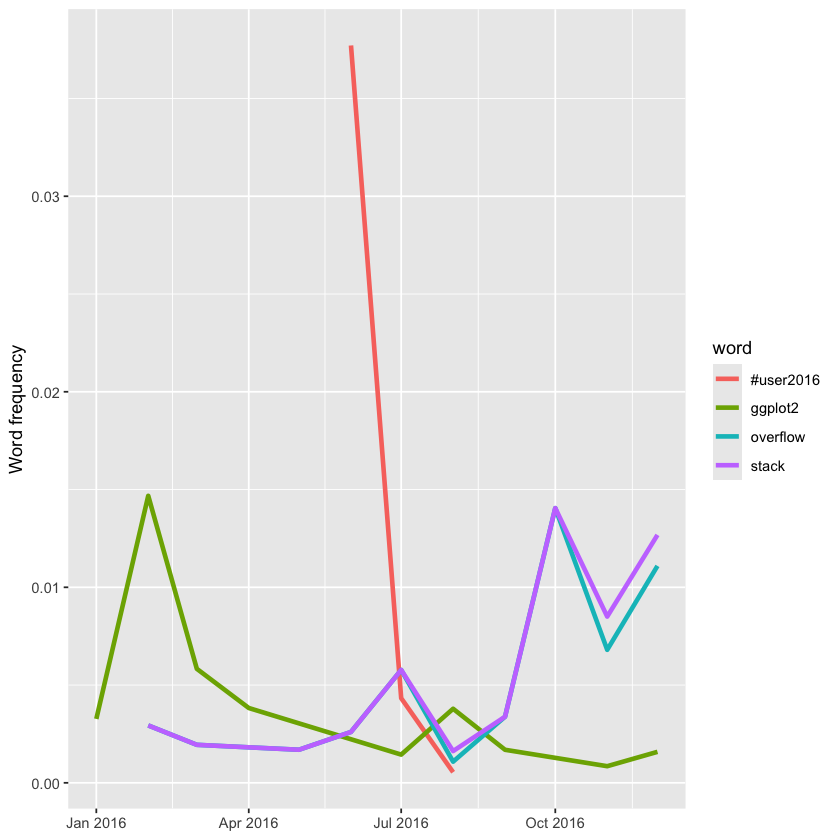

In [22]:
words_by_time %>%
  inner_join(top_slopes, by = c("word", "person")) %>%
  filter(person == "David") %>%
  ggplot(aes(time_floor, count/time_total, color = word)) +
  geom_line(linewidth = 1.3) +
  labs(x = NULL, y = "Word frequency")

This shows that David tweeted extensively about the UseR conference during the event, but his mentions dropped off quickly afterward. Additionally, his tweets about Stack Overflow increased toward the end of the year, while references to ggplot2 declined over time.

Now let’s plot words that have changed frequency in Julia’s tweets.


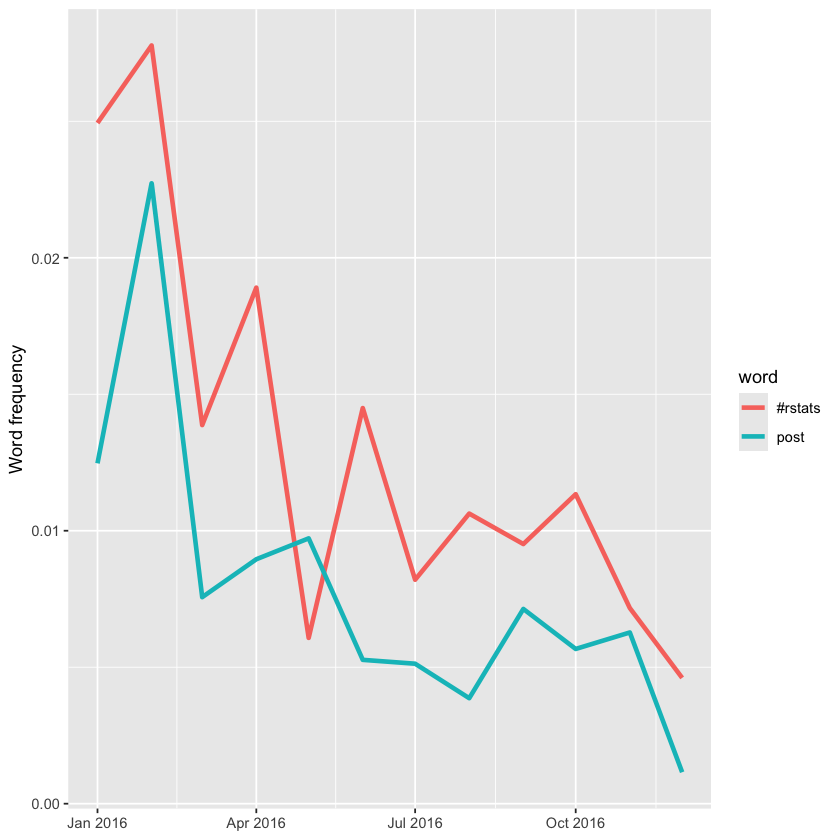

In [23]:
words_by_time %>%
  inner_join(top_slopes, by = c("word", "person")) %>%
  filter(person == "Julia") %>%
  ggplot(aes(time_floor, count/time_total, color = word)) +
  geom_line(linewidth = 1.3) +
  labs(x = NULL, y = "Word frequency")

All of Julia’s significant slopes are negative, indicating she hasn’t increased her use of any particular words over the year. Instead, she’s used a wider variety of words, with the ones shown in this plot appearing more frequently earlier in the year. For example, words related to sharing new blog posts—like the hashtag #rstats and the word “post”—have decreased in usage over time.

### Favorites and Retweets

Another key aspect of tweets is how often they get favorited or retweeted. To analyze which words are associated with higher engagement on Julia’s and David’s tweets, they created a separate dataset that includes favorites and retweets information. Since Twitter archives don’t include this data, they collected roughly 3,200 tweets for each of them directly from the Twitter API, covering about the last 18 months of activity—a period during which both of them increased their tweeting frequency and follower counts.


In [24]:
tweets_julia <- read_csv("data/juliasilge_tweets.csv", show_col_types = FALSE)
tweets_dave <- read_csv("data/drob_tweets.csv", show_col_types = FALSE)
tweets <- bind_rows(tweets_julia %>% 
                      mutate(person = "Julia"),
                    tweets_dave %>% 
                      mutate(person = "David")) %>%
  mutate(created_at = ymd_hms(created_at))

Now that we have this smaller, more recent dataset, we’ll again use [`unnest_tokens()`](https://juliasilge.github.io/tidytext/reference/unnest_tokens.html) to convert the tweets into a tidy format. We’ll filter out all retweets and replies to focus solely on the original tweets posted directly by David and Julia.

In [25]:
tidy_tweets <- tweets %>% 
  filter(!str_detect(text, "^(RT|@)")) %>%
  mutate(text = str_replace_all(text, replace_reg, "")) %>%
  unnest_tokens(word, text, token = "regex", pattern = unnest_reg) %>%
  filter(!word %in% stop_words$word,
         !word %in% str_remove_all(stop_words$word, "'"))

print(tidy_tweets)

# A tibble: 11,074 x 7
        id created_at          source            retweets favorites person word 
     <dbl> <dttm>              <chr>                <dbl>     <dbl> <chr>  <chr>
 1 8.04e17 2016-12-01 16:44:03 Twitter Web Clie~        0         0 Julia  score
 2 8.04e17 2016-12-01 16:44:03 Twitter Web Clie~        0         0 Julia  50   
 3 8.04e17 2016-12-01 16:42:03 Twitter Web Clie~        0         9 Julia  snow~
 4 8.04e17 2016-12-01 16:42:03 Twitter Web Clie~        0         9 Julia  drin~
 5 8.04e17 2016-12-01 16:42:03 Twitter Web Clie~        0         9 Julia  tea  
 6 8.04e17 2016-12-01 16:42:03 Twitter Web Clie~        0         9 Julia  #rst~
 7 8.04e17 2016-12-01 02:56:10 Twitter Web Clie~        0        11 Julia  julie
 8 8.04e17 2016-12-01 02:56:10 Twitter Web Clie~        0        11 Julia  help~
 9 8.04e17 2016-12-01 02:56:10 Twitter Web Clie~        0        11 Julia  pyth~
10 8.04e17 2016-12-01 02:56:10 Twitter Web Clie~        0        11 Julia  pack~
# i 1

First, let’s examine how many times each person’s tweets were retweeted. We’ll calculate the total retweet count separately for David and Julia.

In [26]:
totals <- tidy_tweets %>% 
  group_by(person, id) %>% 
  summarise(rts = first(retweets)) %>% 
  group_by(person) %>% 
  summarise(total_rts = sum(rts))

print(totals)

`summarise()` has grouped output by 'person'. You can override using the
`.groups` argument.


# A tibble: 2 x 2
  person total_rts
  <chr>      <dbl>
1 David      13012
2 Julia       1749


Next, let’s calculate the median number of retweets for each word and person. To avoid counting duplicate tweet/word pairs, we’ll use [`group_by()`](https://dplyr.tidyverse.org/reference/group_by.html) and [`summarise()`](https://dplyr.tidyverse.org/reference/summarise.html) twice in succession. The first [`summarise()`](https://dplyr.tidyverse.org/reference/summarise.html) calculates how many times each word was retweeted, grouped by tweet and person. In the second [`summarise()`](https://dplyr.tidyverse.org/reference/summarise.html), we compute the median retweets for each word and person, while also counting how many times each word appeared overall for each person, saving that as `uses`. After that, we can join this to the data frame containing total retweet counts. Finally, we’ll use [`filter()`](https://dplyr.tidyverse.org/reference/filter.html) to keep only the words that were mentioned at least five times.


In [27]:
word_by_rts <- tidy_tweets %>% 
  group_by(id, word, person) %>% 
  summarise(rts = first(retweets)) %>% 
  group_by(person, word) %>% 
  summarise(retweets = median(rts), uses = n()) %>%
  left_join(totals) %>%
  filter(retweets != 0) %>%
  ungroup()

word_by_rts %>% 
  filter(uses >= 5) %>%
  arrange(desc(retweets)) %>%
  print()

`summarise()` has grouped output by 'id', 'word'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'person'. You can override using the
`.groups` argument.
Joining with `by = join_by(person)`


# A tibble: 178 x 5
   person word          retweets  uses total_rts
   <chr>  <chr>            <dbl> <int>     <dbl>
 1 David  animation         85       5     13012
 2 David  download          52       5     13012
 3 David  start             51       7     13012
 4 Julia  tidytext          50       7      1749
 5 David  gganimate         45       8     13012
 6 David  introducing       45       6     13012
 7 David  understanding     37       6     13012
 8 David  0                 35       7     13012
 9 David  error             34.5     8     13012
10 David  bayesian          34       7     13012
# i 168 more rows


At the top of this sorted data frame, the most retweeted words for both Julia and David relate to packages they contribute to, such as [*gganimate*](https://gganimate.com) and [*tidytext*](https://cran.r-project.org/web/packages/tidytext/index.html). Next, we can create a plot showing the words with the highest median retweet counts for each account, highlighting which terms tend to garner more engagement on their tweets.

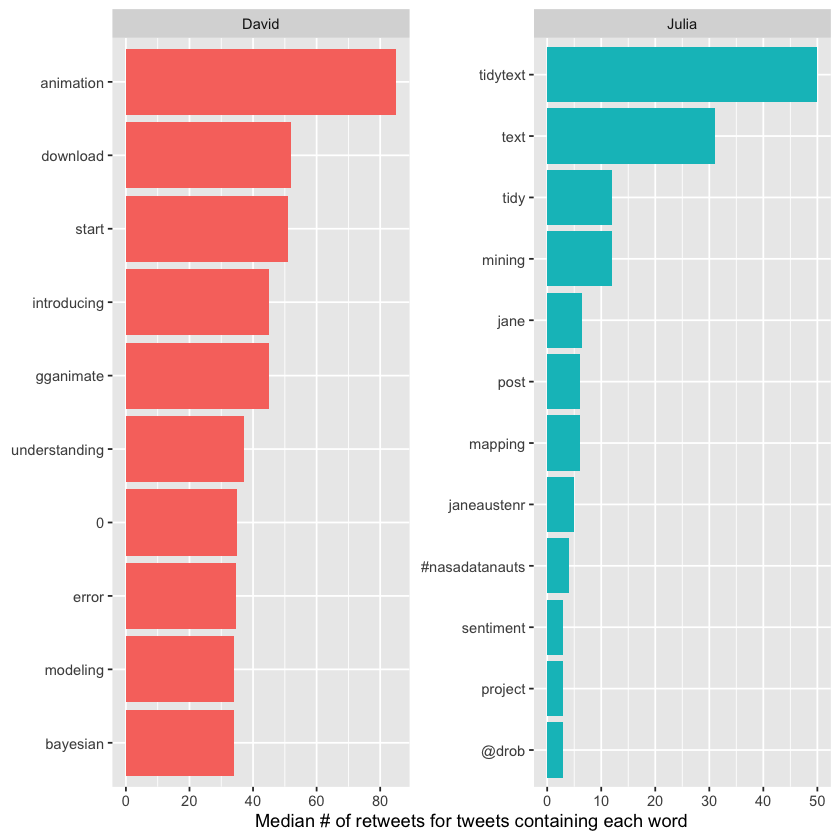

In [28]:
word_by_rts %>%
  filter(uses >= 5) %>%
  group_by(person) %>%
  slice_max(retweets, n = 10) %>% 
  arrange(retweets) %>%
  ungroup() %>%
  mutate(word = factor(word, unique(word))) %>%
  ungroup() %>%
  ggplot(aes(word, retweets, fill = person)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ person, scales = "free", ncol = 2) +
  coord_flip() +
  labs(x = NULL, 
       y = "Median # of retweets for tweets containing each word")

We notice many words related to R packages, including *tidytext*—the very package this book focuses on! The “0” values for David come from tweets mentioning package version numbers, like [“broom 0.4.0”](https://x.com/drob/status/671430703234576384) and similar.

Using a similar approach, we can analyze which words correspond to higher numbers of favorites. It will be interesting to see whether those words differ from the ones that lead to more retweets.

In [29]:
totals <- tidy_tweets %>% 
  group_by(person, id) %>% 
  summarise(favs = first(favorites)) %>% 
  group_by(person) %>% 
  summarise(total_favs = sum(favs))

word_by_favs <- tidy_tweets %>% 
  group_by(id, word, person) %>% 
  summarise(favs = first(favorites)) %>% 
  group_by(person, word) %>% 
  summarise(favorites = median(favs), uses = n()) %>%
  left_join(totals) %>%
  filter(favorites != 0) %>%
  ungroup()

`summarise()` has grouped output by 'person'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'id', 'word'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'person'. You can override using the
`.groups` argument.
Joining with `by = join_by(person)`


We have built the data frames we need. Now let’s make our visualization.

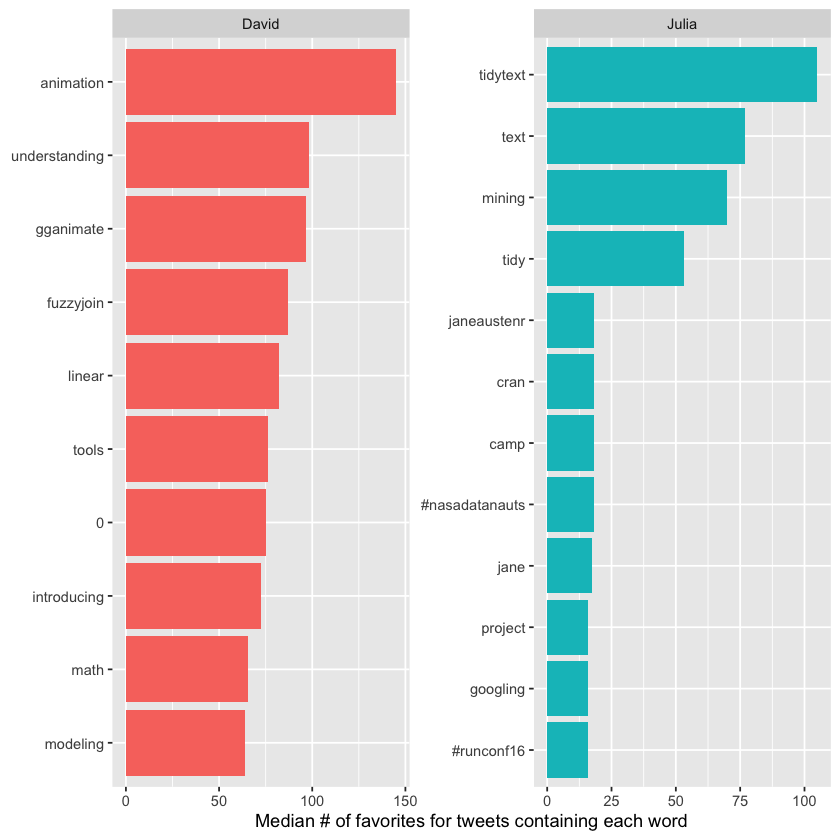

In [30]:
word_by_favs %>%
  filter(uses >= 5) %>%
  group_by(person) %>%
  slice_max(favorites, n = 10) %>% 
  arrange(favorites) %>%
  ungroup() %>%
  mutate(word = factor(word, unique(word))) %>%
  ungroup() %>%
  ggplot(aes(word, favorites, fill = person)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ person, scales = "free", ncol = 2) +
  coord_flip() +
  labs(x = NULL, 
       y = "Median # of favorites for tweets containing each word")

We notice some small differences between David and Julia, especially toward the lower end of the top 10 lists, but overall the words are mostly the same as those linked to retweets. Generally, the words that attract retweets also tend to attract favorites. A standout word for Julia in both charts is the hashtag for the NASA Datanauts program she’s been involved with.

## Case Study: Analyzing Usenet Text

In our final chapter, we’ll apply the techniques from this book to complete an end-to-end analysis of 20,000 messages posted to 20 Usenet bulletin boards in 1993. These bulletin boards cover a variety of topics such as politics, religion, cars, sports, and cryptography, providing a diverse collection of user-generated text. This dataset is publicly available at [http://qwone.com/\~jason/20Newsgroups/](http://qwone.com/~jason/20Newsgroups/) (specifically the `20news-bydate.tar.gz` file) and is widely used for text analysis and machine learning exercises.


### Pre-processing

We’ll begin by reading all the messages from the `20news-bydate` folder, where the files are organized into sub-folders, with one file per message. We can load these files using a combination of [`read_lines()`](https://readr.tidyverse.org/reference/read_lines.html), [`map()`](https://purrr.tidyverse.org/reference/map.html), and [`unnest()`](https://tidyr.tidyverse.org/reference/unnest.html).

Keep in mind that this step may take several minutes to process all the documents.

In [ ]:
library(dplyr)
library(tidyr)
library(purrr)
library(readr)

In [44]:
training_folder <- "data/20news-bydate/20news-bydate-train/"

# Define a function to read all files from a folder into a data frame
read_folder <- function(infolder) {
  tibble(file = dir(infolder, full.names = TRUE)) %>%
    mutate(text = map(file, read_lines)) %>%
    transmute(id = basename(file), text) %>%
    unnest(text)
}

# Use unnest() and map() to apply read_folder to each subfolder
raw_text <- tibble(folder = dir(training_folder, full.names = TRUE)) %>%
  mutate(folder_out = map(folder, read_folder)) %>%
  unnest(cols = c(folder_out)) %>%
  transmute(newsgroup = basename(folder), id, text)

In [45]:
print(raw_text)

# A tibble: 511,617 x 3
   newsgroup   id    text                                                       
   <chr>       <chr> <chr>                                                      
 1 alt.atheism 49960 "From: mathew <mathew@mantis.co.uk>"                       
 2 alt.atheism 49960 "Subject: Alt.Atheism FAQ: Atheist Resources"              
 3 alt.atheism 49960 "Summary: Books, addresses, music -- anything related to a~
 4 alt.atheism 49960 "Keywords: FAQ, atheism, books, music, fiction, addresses,~
 5 alt.atheism 49960 "Expires: Thu, 29 Apr 1993 11:57:19 GMT"                   
 6 alt.atheism 49960 "Distribution: world"                                      
 7 alt.atheism 49960 "Organization: Mantis Consultants, Cambridge. UK."         
 8 alt.atheism 49960 "Supersedes: <19930301143317@mantis.co.uk>"                
 9 alt.atheism 49960 "Lines: 290"                                               
10 alt.atheism 49960 ""                                                         
# i 

Take note of the `newsgroup` column, which indicates the specific newsgroup each message belongs to, and the `id` column, which provides a unique identifier for each message within that group. Let’s explore which newsgroups are included and how many messages were posted in each one.

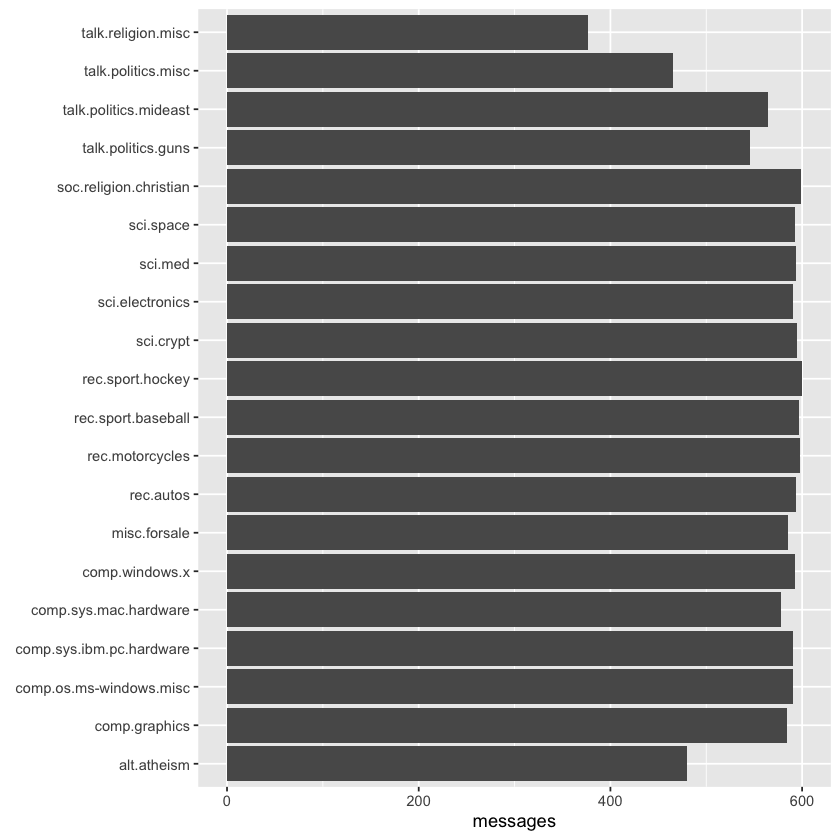

In [46]:
library(ggplot2)

raw_text %>%
  group_by(newsgroup) %>%
  summarize(messages = n_distinct(id)) %>%
  ggplot(aes(messages, newsgroup)) +
  geom_col() +
  labs(y = NULL)

We can observe that Usenet newsgroup names follow a hierarchical structure, beginning with a broad category like “talk,” “sci,” or “rec,” and then narrowing down with more specific subtopics.

#### Pre-processing Text

Most of the datasets we’ve worked with in this book were already pre-processed, so we didn’t have to remove things like copyright notices from the Jane Austen novels. In this case, though, each message includes additional structure and text that we’ll want to exclude from our analysis. For instance, every message contains a header with fields like “from:” or “in\_reply\_to:” that provide metadata about the message. Some messages also include automated email signatures, often starting after a line containing `--`.

We can handle this type of pre-processing using the **dplyr** package, combining functions like [`cumsum()`](https://rdrr.io/r/base/cumsum.html) (cumulative sum) with [`str_detect()`](https://stringr.tidyverse.org/reference/str_detect.html) from the **stringr** package.



In [47]:
library(stringr)

# must occur after the first occurrence of an empty line,
# and before the first occurrence of a line starting with --
cleaned_text <- raw_text %>%
  group_by(newsgroup, id) %>%
  filter(cumsum(text == "") > 0,
         cumsum(str_detect(text, "^--")) == 0) %>%
  ungroup()

Many lines also contain quoted text from other users, often introduced by a line such as “so-and-so writes...”. We can filter these out using a few regular expressions.

Additionally, we’ll manually remove two specific messages, `9704` and `9985`, as they contain a significant amount of non-text content.


In [48]:
cleaned_text <- cleaned_text %>%
  filter(str_detect(text, "^[^>]+[A-Za-z\\d]") | text == "",
         !str_detect(text, "writes(:|\\.\\.\\.)$"),
         !str_detect(text, "^In article <"),
         !id %in% c(9704, 9985))

At this stage, we’re ready to apply [`unnest_tokens()`](https://juliasilge.github.io/tidytext/reference/unnest_tokens.html) to break the dataset into individual tokens, filtering out stop words in the process.

In [49]:
library(tidytext)

usenet_words <- cleaned_text %>%
  unnest_tokens(word, text) %>%
  filter(str_detect(word, "[a-z']$"),
         !word %in% stop_words$word)

Each raw text dataset will need its own unique cleaning process, often involving some trial and error and investigation of atypical cases. It’s worth noting that this cleaning can be effectively done using tidy tools like **dplyr** and **tidyr**.

### Words in Newsgroups

With headers, signatures, and formatting removed, we can begin exploring frequently used words. For example, we might identify the most common words across the entire dataset or focus on specific newsgroups.

In [51]:
usenet_words %>%
  count(word, sort = TRUE) %>%
  print()

# A tibble: 65,918 x 2
   word            n
   <chr>       <int>
 1 people       3656
 2 time         2709
 3 god          1627
 4 system       1610
 5 space        1135
 6 windows      1126
 7 program      1103
 8 bit          1101
 9 information  1094
10 government   1084
# i 65,908 more rows


In [52]:
words_by_newsgroup <- usenet_words %>%
  count(newsgroup, word, sort = TRUE) %>%
  ungroup()

print(words_by_newsgroup)

# A tibble: 173,417 x 3
   newsgroup               word          n
   <chr>                   <chr>     <int>
 1 soc.religion.christian  god         917
 2 sci.space               space       902
 3 talk.politics.mideast   people      729
 4 sci.crypt               key         704
 5 comp.os.ms-windows.misc windows     638
 6 talk.politics.mideast   armenian    583
 7 sci.crypt               db          549
 8 talk.politics.mideast   turkish     515
 9 rec.autos               car         512
10 talk.politics.mideast   armenians   509
# i 173,407 more rows


#### Finding tf-idf Within Newsgroups

Since newsgroups vary by topic and content, we’d expect word frequencies to differ across them. Let’s quantify this difference using the tf-idf metric.



In [53]:
tf_idf <- words_by_newsgroup %>%
  bind_tf_idf(word, newsgroup, n) %>%
  arrange(desc(tf_idf))

print(tf_idf)

# A tibble: 173,417 x 6
   newsgroup                word               n      tf   idf tf_idf
   <chr>                    <chr>          <int>   <dbl> <dbl>  <dbl>
 1 comp.sys.ibm.pc.hardware scsi             485 0.0173   1.20 0.0209
 2 talk.politics.mideast    armenian         583 0.00805  2.30 0.0185
 3 rec.motorcycles          bike             324 0.0137   1.20 0.0165
 4 talk.politics.mideast    armenians        509 0.00703  2.30 0.0162
 5 sci.crypt                encryption       410 0.00802  1.90 0.0152
 6 rec.sport.hockey         hockey           293 0.00815  1.61 0.0131
 7 rec.sport.hockey         nhl              157 0.00437  3.00 0.0131
 8 talk.politics.misc       stephanopoulos   158 0.00417  3.00 0.0125
 9 rec.motorcycles          bikes             97 0.00410  3.00 0.0123
10 comp.windows.x           oname            136 0.00347  3.00 0.0104
# i 173,407 more rows


We can explore the highest tf-idf values for selected groups to identify words unique to those topics. For instance, we might focus on all the `sci.` boards.

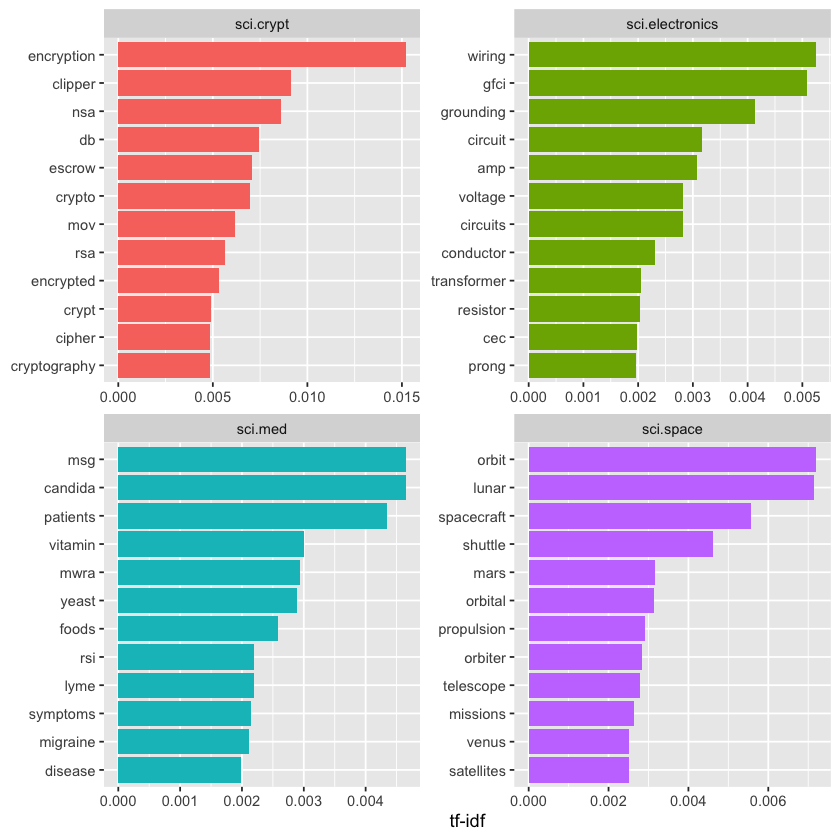

In [54]:
tf_idf %>%
  filter(str_detect(newsgroup, "^sci\\.")) %>%
  group_by(newsgroup) %>%
  slice_max(tf_idf, n = 12) %>%
  ungroup() %>%
  mutate(word = reorder(word, tf_idf)) %>%
  ggplot(aes(tf_idf, word, fill = newsgroup)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ newsgroup, scales = "free") +
  labs(x = "tf-idf", y = NULL)

We observe many distinctive words tied to specific newsgroups, like “wiring” and “circuit” in *sci.electronics* and “orbit” and “lunar” in the space newsgroup. You can use this same approach to explore other newsgroups on your own.

Which newsgroups show similar text content? We can investigate this by calculating the pairwise correlation of word frequencies between newsgroups using the [`pairwise_cor()`](https://juliasilge.github.io/widyr/reference/pairwise_cor.html) function from the **widyr** package.


In [55]:
library(widyr)

newsgroup_cors <- words_by_newsgroup %>%
  pairwise_cor(newsgroup, word, n, sort = TRUE)

print(newsgroup_cors)

# A tibble: 380 x 3
   item1                    item2                    correlation
   <chr>                    <chr>                          <dbl>
 1 talk.religion.misc       soc.religion.christian         0.835
 2 soc.religion.christian   talk.religion.misc             0.835
 3 alt.atheism              talk.religion.misc             0.773
 4 talk.religion.misc       alt.atheism                    0.773
 5 alt.atheism              soc.religion.christian         0.744
 6 soc.religion.christian   alt.atheism                    0.744
 7 comp.sys.mac.hardware    comp.sys.ibm.pc.hardware       0.675
 8 comp.sys.ibm.pc.hardware comp.sys.mac.hardware          0.675
 9 rec.sport.baseball       rec.sport.hockey               0.574
10 rec.sport.hockey         rec.sport.baseball             0.574
# i 370 more rows


Next, we can filter for stronger correlations between newsgroups and visualize these relationships as a network.


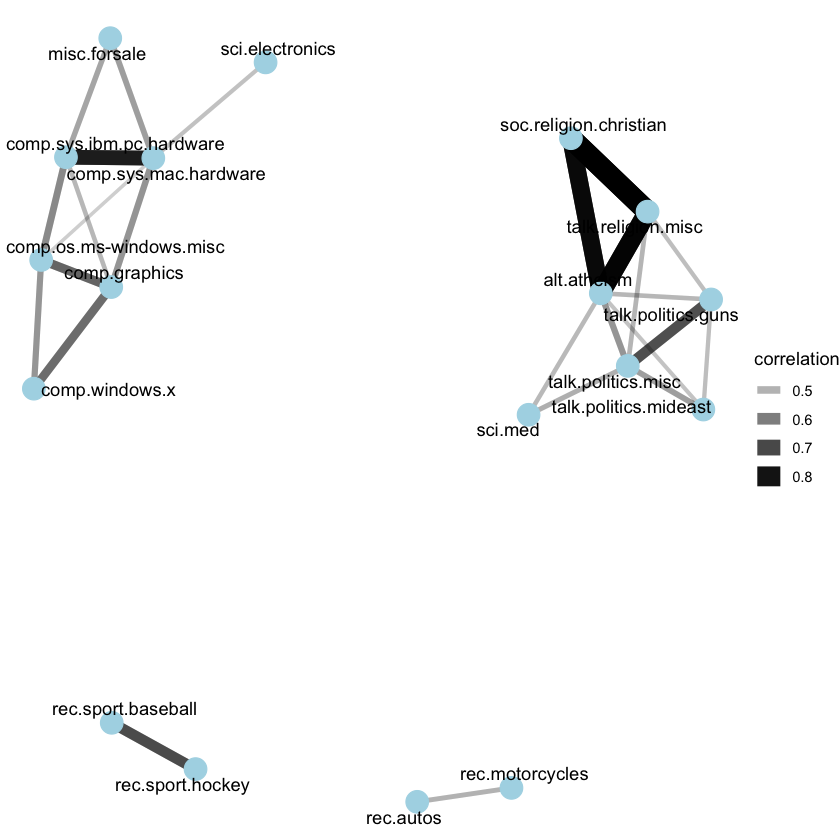

In [58]:
library(ggraph)
library(igraph)
set.seed(2017)

newsgroup_cors %>%
  filter(correlation > .4) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(alpha = correlation, width = correlation)) +
  geom_node_point(size = 6, color = "lightblue") +
  geom_node_text(aes(label = name), repel = TRUE) +
  theme_void()

It appears there are four main clusters of newsgroups: computers and electronics, politics and religion, motor vehicles, and sports. This grouping aligns well with the words and topics we would expect these newsgroups to share.


#### Topic Modeling

Previously, we used Latent Dirichlet Allocation (LDA) to separate chapters back into their original books. Could LDA also classify Usenet messages by their respective newsgroups?

Let’s test this by dividing messages from four science-related newsgroups. First, we convert the data into a document-term matrix using [`cast_dtm()`](https://juliasilge.github.io/tidytext/reference/document_term_casters.html), then fit the model with the [`LDA()`](https://rdrr.io/cran/topicmodels/man/lda.html) function from the **topicmodels** package.

In [59]:
# include only words that occur at least 50 times
word_sci_newsgroups <- usenet_words %>%
  filter(str_detect(newsgroup, "^sci")) %>%
  group_by(word) %>%
  mutate(word_total = n()) %>%
  ungroup() %>%
  filter(word_total > 50)

# convert into a document-term matrix
# with document names such as sci.crypt_14147
sci_dtm <- word_sci_newsgroups %>%
  unite(document, newsgroup, id) %>%
  count(document, word) %>%
  cast_dtm(document, word, n)

In [60]:
library(topicmodels)
sci_lda <- LDA(sci_dtm, k = 4, control = list(seed = 2016))

What four topics did this model identify, and how well did they correspond to the original newsgroups? This method should be familiar we will visualize each topic by highlighting its most frequent terms.


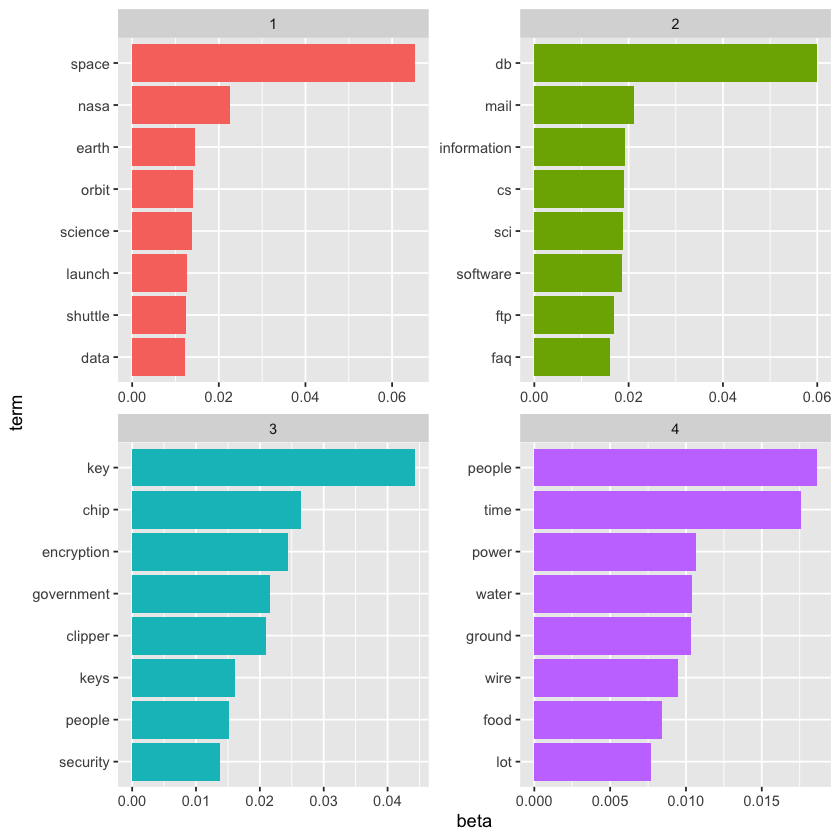

In [61]:
sci_lda %>%
  tidy() %>%
  group_by(topic) %>%
  slice_max(beta, n = 8) %>%
  ungroup() %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(beta, term, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  scale_y_reordered()

Based on the top words, we can begin to infer which topics correspond to which newsgroups. Topic 1 clearly represents *sci.space*, as indicated by “space” being the most frequent word, while topic 2 likely relates to cryptography, featuring terms like “key” and “encryption.” We can validate this by examining how documents from each newsgroup have higher gamma, $\gamma$, values for their respective topics.


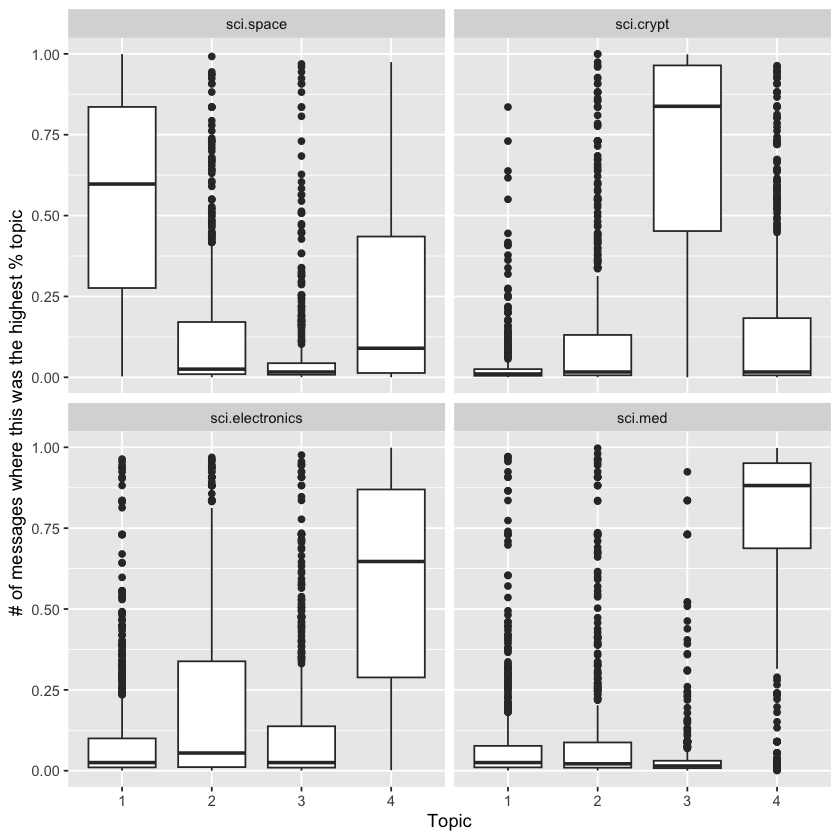

In [62]:
sci_lda %>%
  tidy(matrix = "gamma") %>%
  separate(document, c("newsgroup", "id"), sep = "_") %>%
  mutate(newsgroup = reorder(newsgroup, gamma * topic)) %>%
  ggplot(aes(factor(topic), gamma)) +
  geom_boxplot() +
  facet_wrap(~ newsgroup) +
  labs(x = "Topic",
       y = "# of messages where this was the highest % topic")

As we saw in the literature example, topic modeling successfully identified distinct topics in the text without using the original labels.

However, the separation of Usenet messages was less clear-cut than the division of book chapters. Many messages from each newsgroup showed high gamma, $\gamma$, values for multiple topics. This is expected since many messages are brief and may share vocabulary—for instance, conversations about space travel might overlap with terms used in electronics discussions. This example realistically illustrates how LDA assigns documents to broad topics while permitting some overlap.


### Sentiment Analysis

We can apply the sentiment analysis methods from before to assess the frequency of positive and negative words in these Usenet posts. Which newsgroups tend to be the most positive or negative overall?

For this example, we’ll use the AFINN sentiment lexicon, which assigns numeric sentiment scores to words, and display the results using a bar plot.


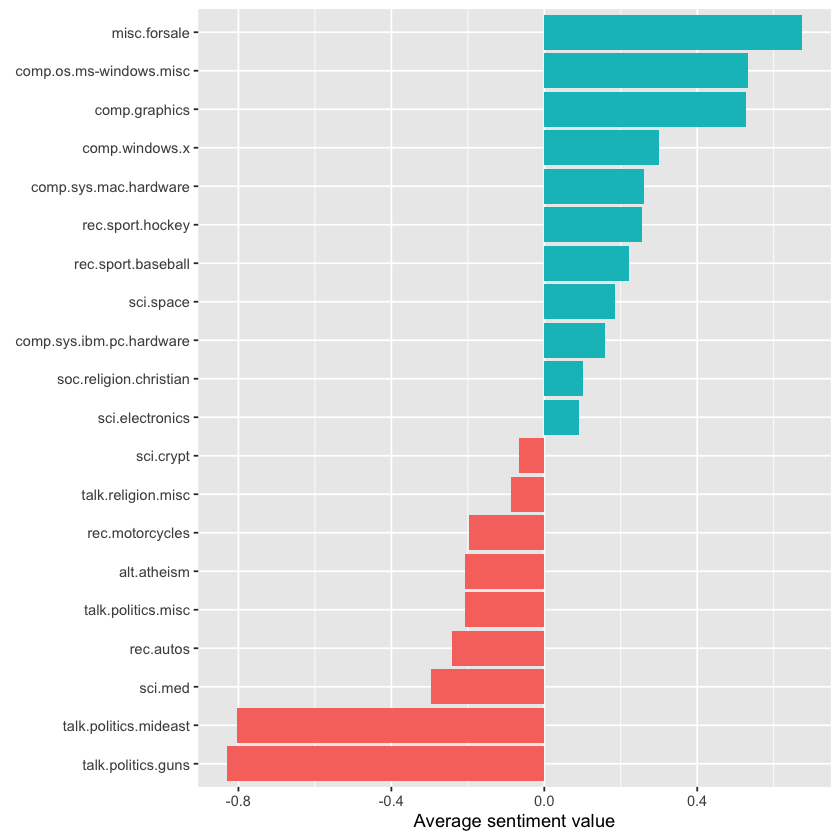

In [63]:
newsgroup_sentiments <- words_by_newsgroup %>%
  inner_join(get_sentiments("afinn"), by = "word") %>%
  group_by(newsgroup) %>%
  summarize(value = sum(value * n) / sum(n))

newsgroup_sentiments %>%
  mutate(newsgroup = reorder(newsgroup, value)) %>%
  ggplot(aes(value, newsgroup, fill = value > 0)) +
  geom_col(show.legend = FALSE) +
  labs(x = "Average sentiment value", y = NULL)

This analysis shows that the “misc.forsale” newsgroup was the most positive overall. This is understandable, as users probably used many positive adjectives when describing items they wanted to sell!

#### Sentiment Analysis by Word

It’s helpful to explore further to see *why* certain newsgroups scored as more positive or negative. To do this, we can analyze the overall positive and negative contributions of individual words.

In [66]:
contributions <- usenet_words %>%
  inner_join(get_sentiments("afinn"), by = "word") %>%
  group_by(word) %>%
  summarize(occurences = n(),
            contribution = sum(value))

print(contributions)

# A tibble: 1,909 x 3
   word      occurences contribution
   <chr>          <int>        <dbl>
 1 abandon           13          -26
 2 abandoned         19          -38
 3 abandons           3           -6
 4 abduction          2           -4
 5 abhor              4          -12
 6 abhorred           1           -3
 7 abhorrent          2           -6
 8 abilities         16           32
 9 ability          177          354
10 aboard             8            8
# i 1,899 more rows


Which words had the most effect on sentiment values overall?

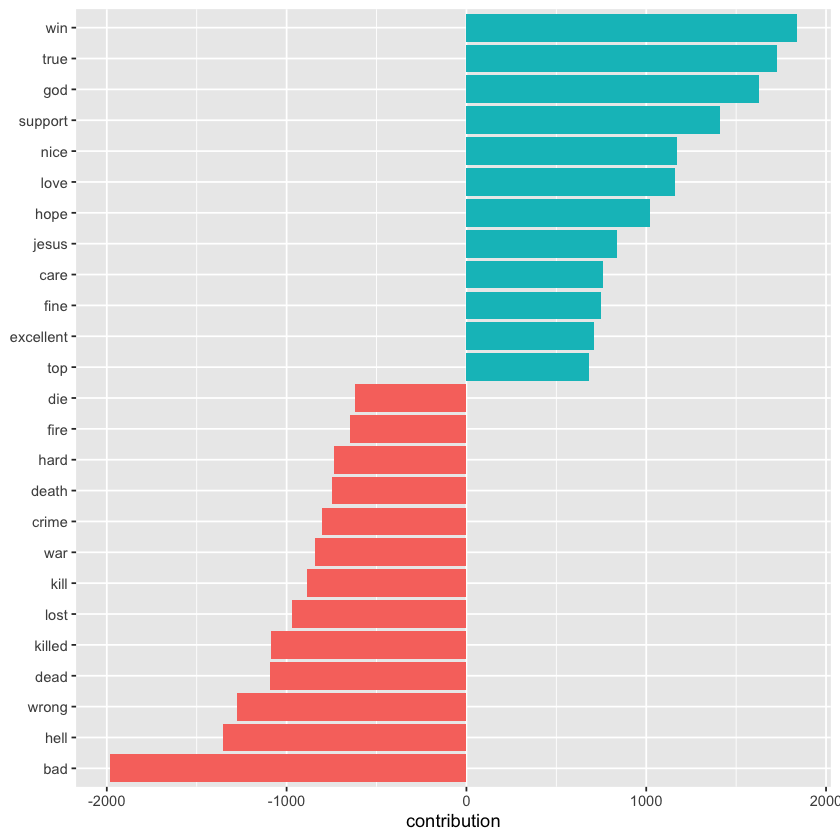

In [67]:
contributions %>%
  slice_max(abs(contribution), n = 25) %>%
  mutate(word = reorder(word, contribution)) %>%
  ggplot(aes(contribution, word, fill = contribution > 0)) +
  geom_col(show.legend = FALSE) +
  labs(y = NULL)

These words generally seem like reasonable indicators of sentiment, but some issues are apparent. For example, “true” might appear in negative phrases like “not true,” and words like “God” and “Jesus” are frequent on Usenet but could be used in both positive and negative contexts.

We may also want to examine which words contribute most to sentiment *within each newsgroup*, helping identify any newsgroups where the sentiment estimates might be misleading.


In [68]:
top_sentiment_words <- words_by_newsgroup %>%
  inner_join(get_sentiments("afinn"), by = "word") %>%
  mutate(contribution = value * n / sum(n))

We can compute how much each word contributes to the sentiment score of each newsgroup and then visualize the most influential words from a selection of groups.


In [69]:
print(top_sentiment_words)

# A tibble: 13,078 x 5
   newsgroup              word       n value contribution
   <chr>                  <chr>  <int> <dbl>        <dbl>
 1 soc.religion.christian god      917     1      0.0144 
 2 soc.religion.christian jesus    440     1      0.00690
 3 talk.politics.guns     gun      425    -1     -0.00667
 4 talk.religion.misc     god      296     1      0.00464
 5 alt.atheism            god      268     1      0.00421
 6 soc.religion.christian faith    257     1      0.00403
 7 talk.religion.misc     jesus    256     1      0.00402
 8 talk.politics.mideast  killed   202    -3     -0.00951
 9 talk.politics.mideast  war      187    -2     -0.00587
10 soc.religion.christian true     179     2      0.00562
# i 13,068 more rows


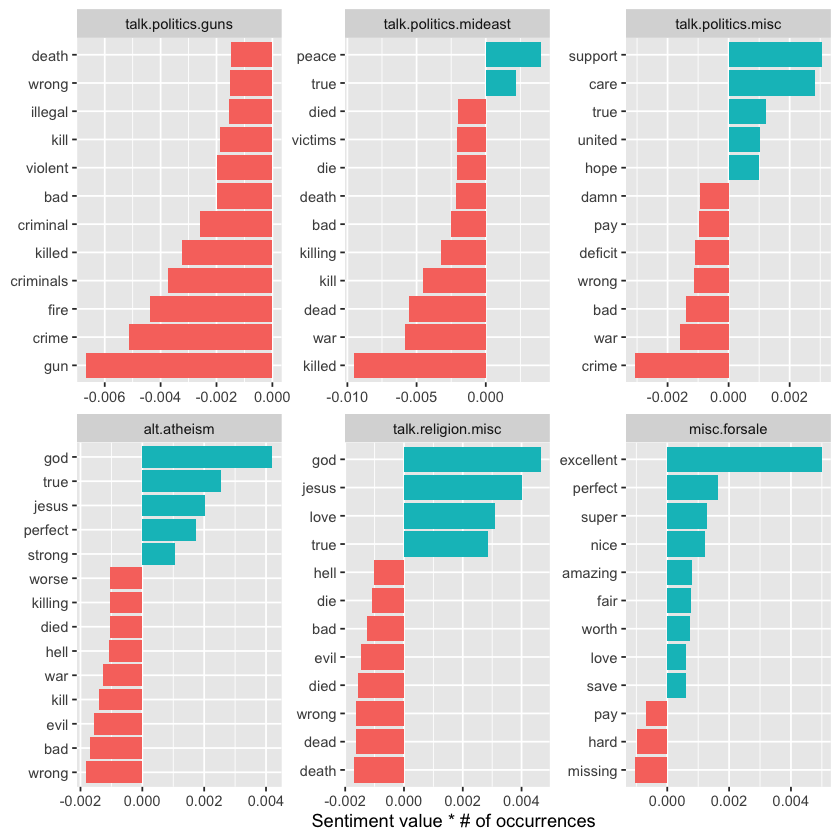

In [70]:
top_sentiment_words %>%
  filter(str_detect(newsgroup, "^(talk|alt|misc)")) %>%
  group_by(newsgroup) %>%
  slice_max(abs(contribution), n = 12) %>%
  ungroup() %>%
  mutate(newsgroup = reorder(newsgroup, contribution),
         word = reorder_within(word, contribution, newsgroup)) %>%
  ggplot(aes(contribution, word, fill = contribution > 0)) +
  geom_col(show.legend = FALSE) +
  scale_y_reordered() +
  facet_wrap(~ newsgroup, scales = "free") +
  labs(x = "Sentiment value * # of occurrences", y = NULL)

This supports our earlier guess about the “misc.forsale” newsgroup: most of its positive sentiment comes from adjectives like “excellent” and “perfect.” It also highlights how sentiment can be intertwined with topic. For example, an atheism newsgroup might frequently mention “god” in a negative way, yet this causes the group to appear more positive overall. Likewise, the word “gun” may contribute negatively to the “talk.politics.guns” group even when discussed positively.

This serves as a reminder that sentiment analysis can be influenced by topic, so it’s important to review the key contributing words before drawing strong conclusions.

#### Sentiment Analysis by Message

We can also identify the most positive and negative individual messages by grouping and summarizing the data by `id` instead of by `newsgroup`.


In [71]:
sentiment_messages <- usenet_words %>%
  inner_join(get_sentiments("afinn"), by = "word") %>%
  group_by(newsgroup, id) %>%
  summarize(sentiment = mean(value),
            words = n()) %>%
  ungroup() %>%
  filter(words >= 5)

`summarise()` has grouped output by 'newsgroup'. You can override using the
`.groups` argument.


As a simple measure to reduce the role of randomness, we filtered out messages that had fewer than five words that contributed to sentiment.

What were the most positive messages?

In [73]:
sentiment_messages %>%
  arrange(desc(sentiment)) %>%
  print()

# A tibble: 3,565 x 4
   newsgroup               id     sentiment words
   <chr>                   <chr>      <dbl> <int>
 1 rec.sport.hockey        53560       3.89    18
 2 rec.sport.hockey        53602       3.83    30
 3 rec.sport.hockey        53822       3.83     6
 4 comp.windows.x          66905       3.32    19
 5 comp.windows.x          66906       3.32    19
 6 comp.os.ms-windows.misc 9904        3.29     7
 7 rec.sport.hockey        53645       3.23    13
 8 rec.autos               102768      3.2      5
 9 misc.forsale            75965       3        5
10 misc.forsale            76037       3        5
# i 3,555 more rows


To verify this, let’s examine the most positive message in the entire dataset. To help with this, we can create a simple function that prints a specified message.


In [74]:
print_message <- function(group, message_id) {
  result <- cleaned_text %>%
    filter(newsgroup == group, id == message_id, text != "")
  
  cat(result$text, sep = "\n")
}

print(print_message("rec.sport.hockey", 53560))

Everybody.  Please send me your predictions for the Stanley Cup Playoffs!
I want to see who people think will win.!!!!!!!
Please Send them in this format, or something comparable:
1. Winner of Buffalo-Boston
2. Winner of Montreal-Quebec
3. Winner of Pittsburgh-New York
4. Winner of New Jersey-Washington
5. Winner of Chicago-(Minnesota/St.Louis)
6. Winner of Toronto-Detroit
7. Winner of Vancouver-Winnipeg
8. Winner of Calgary-Los Angeles
9. Winner of Adams Division (1-2 above)
10. Winner of Patrick Division (3-4 above)
11. Winner of Norris Division (5-6 above)
12. Winner of Smythe Division (7-8 above)
13. Winner of Wales Conference (9-10 above)
14. Winner of Campbell Conference (11-12 above)
15. Winner of Stanley Cup (13-14 above)
I will summarize the predictions, and see who is the biggest
INTERNET GURU PREDICTING GUY/GAL.
Send entries to Richard Madison
rrmadiso@napier.uwaterloo.ca
PS:  I will send my entries to one of you folks so you know when I say
I won, that I won!!!!!
NULL


It appears this message was flagged as most positive due to frequent use of the word “winner.” What about the most negative message? Interestingly, it’s also from the hockey site but expresses a very different sentiment.

In [76]:
sentiment_messages %>%
  arrange(sentiment) %>%
  print()

print_message("rec.sport.hockey", 53907)


# A tibble: 3,565 x 4
   newsgroup             id     sentiment words
   <chr>                 <chr>      <dbl> <int>
 1 rec.sport.hockey      53907      -3        6
 2 sci.electronics       53899      -3        5
 3 talk.politics.mideast 75918      -3        7
 4 rec.autos             101627     -2.83     6
 5 comp.graphics         37948      -2.8      5
 6 comp.windows.x        67204      -2.7     10
 7 talk.politics.guns    53362      -2.67     6
 8 alt.atheism           51309      -2.6      5
 9 comp.sys.mac.hardware 51513      -2.6      5
10 rec.autos             102883     -2.6      5
# i 3,555 more rows
Losers like us? You are the fucking moron who has never heard of the Western
Business School, or the University of Western Ontario for that matter. Why 
don't you pull your head out of your asshole and smell something other than
shit for once so you can look on a map to see where UWO is! Back to hockey,
the North Stars should be moved because for the past few years they have
just

#### N-gram Analysis 

Earlier, we examined how words like “not” and “no” affect sentiment analysis of Jane Austen’s novels—such as whether phrases like “don’t like” cause passages to be misclassified as positive. Since the Usenet dataset is a much larger and more contemporary corpus, we might want to explore how sentiment reversal occurs in this text.

To begin, we’ll identify and count all the bigrams in the Usenet posts.

In [77]:
usenet_bigrams <- cleaned_text %>%
  unnest_tokens(bigram, text, token = "ngrams", n = 2)

In [78]:
usenet_bigram_counts <- usenet_bigrams %>%
  count(newsgroup, bigram, sort = TRUE) %>%
  separate(bigram, c("word1", "word2"), sep = " ")

Next, we can define a list of six words likely to indicate negation—such as “no,” “not,” and “without”—and visualize the sentiment-related words that most frequently follow them. This highlights words that often contributed to sentiment in the “wrong” direction.

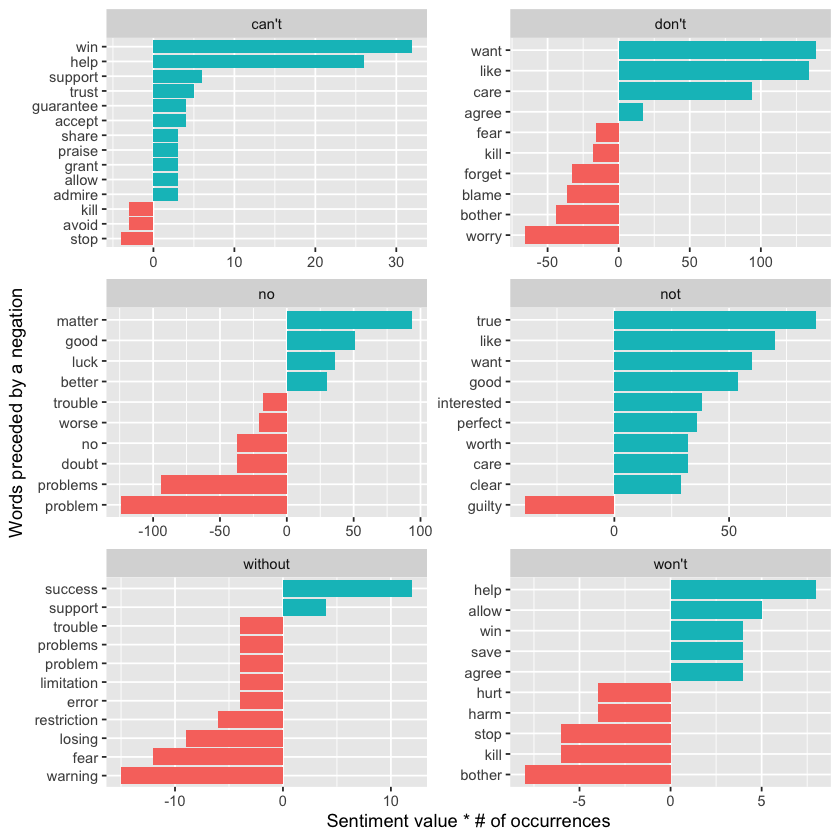

In [79]:
negate_words <- c("not", "without", "no", "can't", "don't", "won't")

usenet_bigram_counts %>%
  filter(word1 %in% negate_words) %>%
  count(word1, word2, wt = n, sort = TRUE) %>%
  inner_join(get_sentiments("afinn"), by = c(word2 = "word")) %>%
  mutate(contribution = value * n) %>%
  group_by(word1) %>%
  slice_max(abs(contribution), n = 10) %>%
  ungroup() %>%
  mutate(word2 = reorder_within(word2, contribution, word1)) %>%
  ggplot(aes(contribution, word2, fill = contribution > 0)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ word1, scales = "free", nrow = 3) +
  scale_y_reordered() +
  labs(x = "Sentiment value * # of occurrences",
       y = "Words preceded by a negation")

It appears that the biggest causes of misclassifying words as positive stem from phrases like “don’t want/like/care,” while the most common source of incorrectly labeled negative sentiment is the phrase “no problem.”

## Acknowledgements
We would like to acknowledge the work of Julia Silge and David Robinson, whose materials were used under the terms of the Creative Commons Attribution-NonCommercial-ShareAlike 3.0 United States License. Their contributions to open data science education, particularly the [Text Mining with R](https://www.tidytextmining.com), provided valuable resources for this project.

This notebook was created by Meara Cox using their code and examples as a foundation, with additional explanations and adaptations to support the goals of this project.